# 1. Load Library

In this section we import all the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import os
import random
import pickle

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder     # Support Sparse Matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay   # Classification metrics

print('Libraries loaded successfully')

Libraries loaded successfully


# 2. Load Dataset

Load the dataset (e.g., a CSV file) and preview it.

In [2]:
from dataloader import load_gdsc, prepare_features, split_data
excluded_columns = ['LN_IC50', 'AUC', 'Z_SCORE', 'DRUG_ID', 'COSMIC_ID', 'DRUG_NAME', 'CELL_LINE_NAME']
df = load_gdsc(excluded_columns=excluded_columns)   # With Drop NaN & Exclude Outlier with IQR

# Create dummy variables for categorical features and split the data into training and testing sets with default test size of 0.2
X_dummy, _ = prepare_features(df, encode_dummies=True)
X_label, _ = prepare_features(df, encode_dummies=False)

# Convert numerical drug response values into categorical classes based on Z-scores
def z_to_label(z):
    if z <= -1:
        return "Sensitive"
    elif z >= 1:
        return "Resistant"
    else:
        return "Intermediate"
y = df['Z_SCORE'].apply(z_to_label)
print(y.value_counts())
y = y.astype('category').cat.codes  # Convert categorical labels to numerical codes (Intermediate = 0, Resistant = 1, Sensitive = 2)

Xd_train, Xd_test, Xl_train, Xl_test, y_train, y_test = split_data(X_dummy, X_label, y) 
# Xd: X features with dummy variables
# Xl: X features with label encoding (e.g. Turn R, G, B into 0, 1, 2)
Xd_train.shape, Xd_test.shape, Xl_train.shape, Xl_test.shape, y_train.shape, y_test.shape

Z_SCORE
Intermediate    116724
Resistant        26308
Sensitive        23612
Name: count, dtype: int64


((133315, 336), (33329, 336), (133315, 12), (33329, 12), (133315,), (33329,))

In [3]:
# print the number of unique values in each non-numeric column
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
print("Unique values in non-numeric columns:")
for col in non_numeric_cols:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values")

Unique values in non-numeric columns:
CELL_LINE_NAME: 751 unique values
TCGA_DESC: 31 unique values
DRUG_NAME: 249 unique values
GDSC Tissue descriptor 1: 17 unique values
GDSC Tissue descriptor 2: 35 unique values
Cancer Type (matching TCGA label): 31 unique values
Microsatellite instability Status (MSI): 2 unique values
Screen Medium: 2 unique values
Growth Properties: 3 unique values
CNA: 2 unique values
Gene Expression: 2 unique values
Methylation: 2 unique values
TARGET: 185 unique values
TARGET_PATHWAY: 24 unique values


# 3. Define Base Learner

Define the base learner that will be used in the different learning methods. For example, a simple Logistic Regression classifier.

In [4]:
offline_seed = 42
# Define the base learner as random forest
base_learner = RandomForestClassifier(
    n_estimators=100,
    random_state=offline_seed,
)
print('Base learner defined:', base_learner)

Base learner defined: RandomForestClassifier(random_state=42)


# 4. Offline Learning Method

Implement the offline (batch) learning method where the base learner is trained on the entire dataset.

Accuracy: 0.6912
Precision: 0.6385
Recall: 0.6912
F1 Score: 0.6454


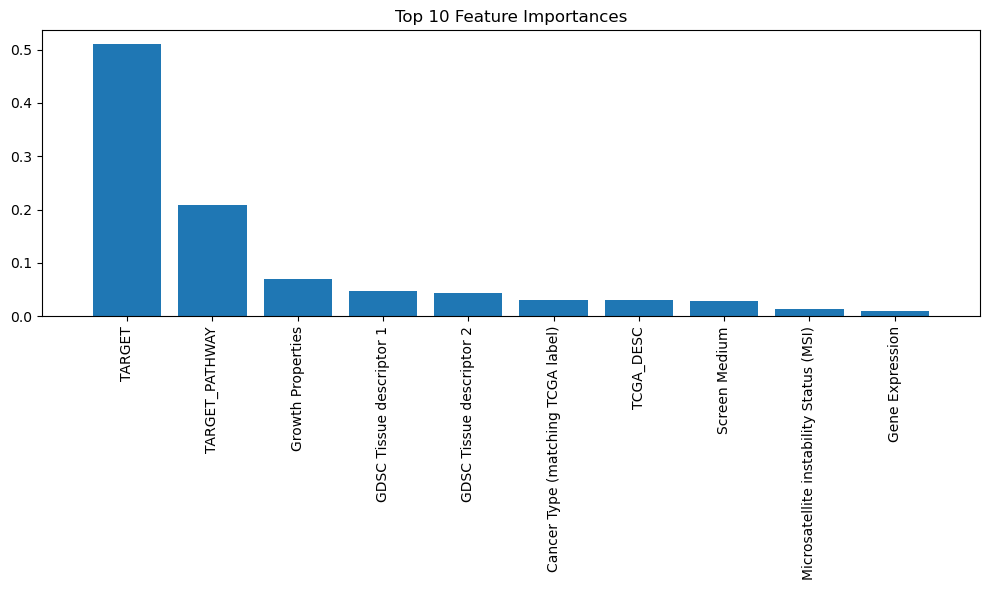

In [5]:
# Train the base learner
base_learner.fit(Xl_train, y_train)

# evaluate the model
y_pred = base_learner.predict(Xl_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # 多分类使用weighted
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Visualize the top 10 feature importances
importances = base_learner.feature_importances_
indices = np.argsort(importances)[::-1][:10]
features = Xl_train.columns[indices]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), importances[indices], align="center")
plt.xticks(range(10), features, rotation=90)
plt.xlim([-1, 10])
plt.tight_layout()
plt.show()

# 5. Passive Learning Method

Implement the passive learning method. This method randomly select instances from sample space for model training.

In [6]:
def random_sampling(X, y, n_samples, random_state):
    """
    Perform random sampling from the dataset in a sparse-compatible way.
    
    Parameters:
    -----------
    X : {array-like, sparse matrix, dataframe} of shape (n_samples, n_features)
        The input samples
    y : array-like of shape (n_samples,)
        The target values
    n_samples : int
        Number of samples to select
    random_state : int or None, optional (default=None)
        Controls the randomness of the sampling
        
    Returns:
    --------
    X_sampled : selected samples
    X_remaining : remaining samples
    y_sampled : selected target values
    y_remaining : remaining target values
    """
    np.random.seed(random_state)
    indices = np.random.permutation(X.shape[0])
    sample_idx = indices[:n_samples]
    remaining_idx = indices[n_samples:]

    if hasattr(X, 'iloc'):  # pandas DataFrame
        X_sampled = X.iloc[sample_idx]
        X_remaining = X.iloc[remaining_idx]
    else:  # numpy array
        X_sampled = X[sample_idx]
        X_remaining = X[remaining_idx]

    if hasattr(y, 'iloc'):  # pandas DataFrame
        y_sampled = y.iloc[sample_idx]
        y_remaining = y.iloc[remaining_idx]
    else:
        y_sampled = y[sample_idx]
        y_remaining = y[remaining_idx]

    return X_sampled, X_remaining, y_sampled, y_remaining

In [7]:
initial_train_size = 0.05   # Percentage of data for initial training, excluding test set
max_train_size = 1.00       # Percentage of data for maximum training size, excluding test set 
n_runs = 5                  # Number of experiments
batch_size = 100           # Batch size for active learning

accuracy_passive = []
f1_passive = []

# Passive learning
for seed in range(n_runs):
    base_learner = RandomForestClassifier(
        n_estimators=100,
        random_state=seed,
        n_jobs=-1,
    )

    # Split the data into training and pool
    X_observed, X_pool, y_observed, y_pool = train_test_split(
        Xl_train, y_train, train_size=initial_train_size, random_state=seed, stratify=y_train)

    initial_samples = int(Xl_train.shape[0] * initial_train_size)
    max_samples = int(Xl_train.shape[0] * max_train_size)
    overall_accuracy = []
    overall_f1 = []

    while X_observed.shape[0] < max_samples:
        model = base_learner.fit(X_observed, y_observed)

        # Evaluate the model on the test set
        y_pred = model.predict(Xl_test)
        overall_accuracy.append(accuracy_score(y_test, y_pred))
        overall_f1.append(f1_score(y_test, y_pred, average='weighted'))

        # Randomly select a sample from the training set
        X_new, X_pool, y_new, y_pool = random_sampling(
            X_pool, y_pool, n_samples=batch_size, random_state=seed)

        # Update the training set with the new sample
        X_observed = pd.concat([X_observed, X_new], ignore_index=True)
        y_observed = pd.concat([y_observed, y_new], ignore_index=True)

        # Verbose output every 1000 samples
        if (X_observed.shape[0] - initial_samples) % 1000 == 0:
            print(f"Training size: {X_observed.shape[0]}, Accuracy: {overall_accuracy[-1]:.2f}, F1: {overall_f1[-1]:.2f}")

    accuracy_passive.append(overall_accuracy)
    f1_passive.append(overall_f1)
    print(f"Seed {seed} done")

# Save results
with open('./results/classification_passive.pkl', 'wb') as f:
    pickle.dump((accuracy_passive, f1_passive), f)

Training size: 7665, Accuracy: 0.63, F1: 0.61
Training size: 8665, Accuracy: 0.63, F1: 0.61
Training size: 9665, Accuracy: 0.63, F1: 0.61
Training size: 10665, Accuracy: 0.63, F1: 0.61
Training size: 11665, Accuracy: 0.63, F1: 0.61
Training size: 12665, Accuracy: 0.63, F1: 0.61
Training size: 13665, Accuracy: 0.63, F1: 0.61
Training size: 14665, Accuracy: 0.63, F1: 0.62
Training size: 15665, Accuracy: 0.64, F1: 0.62
Training size: 16665, Accuracy: 0.64, F1: 0.61
Training size: 17665, Accuracy: 0.64, F1: 0.61
Training size: 18665, Accuracy: 0.64, F1: 0.62
Training size: 19665, Accuracy: 0.64, F1: 0.62
Training size: 20665, Accuracy: 0.64, F1: 0.62
Training size: 21665, Accuracy: 0.64, F1: 0.62
Training size: 22665, Accuracy: 0.65, F1: 0.62
Training size: 23665, Accuracy: 0.65, F1: 0.62
Training size: 24665, Accuracy: 0.65, F1: 0.63
Training size: 25665, Accuracy: 0.65, F1: 0.62
Training size: 26665, Accuracy: 0.65, F1: 0.63
Training size: 27665, Accuracy: 0.65, F1: 0.62
Training size: 2

# 6. Active Learning Method


### 6.1 Uncertainty based method


In [8]:
def uncertainty_sampling(model, X, y, n_samples, random_state=None):
    """
    Perform uncertainty sampling from the dataset based on least confidence.
    
    Parameters:
    -----------
    model : classifier object
        The trained classifier with predict_proba method
    X : {array-like, sparse matrix, dataframe} of shape (n_samples, n_features)
        The input samples
    y : array-like of shape (n_samples,)
        The target values
    n_samples : int
        Number of samples to select
    random_state : int or None, optional (default=None)
        Controls the randomness for tie-breaking
        
    Returns:
    --------
    X_sampled : selected samples
    X_remaining : remaining samples
    y_sampled : selected target values
    y_remaining : remaining target values
    """
    # Calculate prediction probabilities
    y_pred = model.predict_proba(X)
    
    # Calculate least confidence (1 - max class probability)
    max_probs = np.max(y_pred, axis=1)
    least_confidence = 1 - max_probs
    
    # Handle ties with random state
    if random_state is not None:
        np.random.seed(random_state)
    
    # Get indices sorted by least confidence (descending) with random tie-breaking
    sample_idx = np.lexsort((np.random.random(len(least_confidence)), -least_confidence))
    
    # Split indices into sampled and remaining
    sampled_idx = sample_idx[:n_samples]
    remaining_idx = sample_idx[n_samples:]

    # Handle different input types (pandas vs numpy)
    if hasattr(X, 'iloc'):  # pandas DataFrame
        X_sampled = X.iloc[sampled_idx]
        X_remaining = X.iloc[remaining_idx]
    else:  # numpy array or sparse matrix
        X_sampled = X[sampled_idx]
        X_remaining = X[remaining_idx]

    if hasattr(y, 'iloc'):  # pandas Series/DataFrame
        y_sampled = y.iloc[sampled_idx]
        y_remaining = y.iloc[remaining_idx]
    else:
        y_sampled = y[sampled_idx]
        y_remaining = y[remaining_idx]

    return X_sampled, X_remaining, y_sampled, y_remaining

In [9]:
initial_train_size = 0.05   # Percentage of data for initial training, excluding test set
max_train_size = 1.00       # Percentage of data for maximum training size, excluding test set 
n_runs = 5                  # Number of experiments
batch_size = 100           # Batch size for active learning

accuracy_uncertainty = []
f1_uncertainty = []

# Uncertainty sampling
for seed in range(n_runs):
    base_learner = RandomForestClassifier(
        n_estimators=100,
        random_state=seed,
        n_jobs=-1,
    )

    # Split the data into training and pool
    X_observed, X_pool, y_observed, y_pool = train_test_split(
        Xl_train, y_train, train_size=initial_train_size, random_state=seed, stratify=y_train)

    initial_samples = int(Xl_train.shape[0] * initial_train_size)
    max_samples = int(Xl_train.shape[0] * max_train_size)
    overall_accuracy = []
    overall_f1 = []

    while X_observed.shape[0] < max_samples:
        model = base_learner.fit(X_observed, y_observed)

        # Evaluate the model on the test set
        y_pred = model.predict(Xl_test)
        overall_accuracy.append(accuracy_score(y_test, y_pred))
        overall_f1.append(f1_score(y_test, y_pred, average='weighted'))

        # Randomly select a sample from the training set
        X_new, X_pool, y_new, y_pool = uncertainty_sampling(
            model, X_pool, y_pool, n_samples=batch_size, random_state=seed)

        # Update the training set with the new sample
        X_observed = pd.concat([X_observed, X_new], ignore_index=True)
        y_observed = pd.concat([y_observed, y_new], ignore_index=True)

        # Verbose output every 1000 samples
        if (X_observed.shape[0] - initial_samples) % 1000 == 0:
            print(f"Training size: {X_observed.shape[0]}, Accuracy: {overall_accuracy[-1]:.2f}, F1: {overall_f1[-1]:.2f}")

    accuracy_uncertainty.append(overall_accuracy)
    f1_uncertainty.append(overall_f1)
    print(f"Seed {seed} done")

# Save results
with open('./results/classification_uncertainty.pkl', 'wb') as f:
    pickle.dump((accuracy_uncertainty, f1_uncertainty), f)

Training size: 7665, Accuracy: 0.64, F1: 0.61
Training size: 8665, Accuracy: 0.64, F1: 0.61
Training size: 9665, Accuracy: 0.64, F1: 0.62
Training size: 10665, Accuracy: 0.65, F1: 0.62
Training size: 11665, Accuracy: 0.65, F1: 0.62
Training size: 12665, Accuracy: 0.65, F1: 0.62
Training size: 13665, Accuracy: 0.65, F1: 0.62
Training size: 14665, Accuracy: 0.65, F1: 0.62
Training size: 15665, Accuracy: 0.65, F1: 0.62
Training size: 16665, Accuracy: 0.65, F1: 0.62
Training size: 17665, Accuracy: 0.65, F1: 0.62
Training size: 18665, Accuracy: 0.66, F1: 0.62
Training size: 19665, Accuracy: 0.66, F1: 0.62
Training size: 20665, Accuracy: 0.66, F1: 0.62
Training size: 21665, Accuracy: 0.66, F1: 0.62
Training size: 22665, Accuracy: 0.66, F1: 0.62
Training size: 23665, Accuracy: 0.66, F1: 0.63
Training size: 24665, Accuracy: 0.66, F1: 0.63
Training size: 25665, Accuracy: 0.66, F1: 0.63
Training size: 26665, Accuracy: 0.66, F1: 0.63
Training size: 27665, Accuracy: 0.67, F1: 0.63
Training size: 2

### 6.2 Query by committee

In [10]:
def query_by_committee(random_forest, X, y, n_samples, method='soft_vote', random_state=None):
    """
    Query samples from the dataset based on committee disagreement.
    
    Parameters:
    -----------
    random_forest : RandomForestClassifier
        A trained random forest model used as the committee
    X : {array-like, sparse matrix, dataframe} of shape (n_samples, n_features)
        The input samples
    y : array-like of shape (n_samples,)
        The target values
    n_samples : int
        Number of samples to select
    method : str, optional (default='soft_vote')
        Method for calculating disagreement: 'soft_vote' or 'hard_vote'
    random_state : int or None, optional (default=None)
        Controls the randomness for tie-breaking
        
    Returns:
    --------
    X_sampled : selected samples
    X_remaining : remaining samples
    y_sampled : selected target values
    y_remaining : remaining target values
    """
    # Handle random state for tie-breaking
    if random_state is not None:
        np.random.seed(random_state)
    
    if method == 'hard_vote':
        pass
    elif method == 'soft_vote':
        committee_predictions = np.array([tree.predict_proba(X.to_numpy()) for tree in random_forest.estimators_])
        vote_prob = np.mean(committee_predictions, axis=0) + 1e-10
        committee_entropy = -np.sum(vote_prob * np.log(vote_prob), axis=1)
    
    # Get indices sorted by entropy (descending) with random tie-breaking
    sample_idx = np.lexsort((np.random.random(len(committee_entropy)), -committee_entropy))
    
    # Split indices into sampled and remaining
    sampled_idx = sample_idx[:n_samples]
    remaining_idx = sample_idx[n_samples:]

    # Handle different input types (pandas vs numpy)
    if hasattr(X, 'iloc'):  # pandas DataFrame
        X_sampled = X.iloc[sampled_idx]
        X_remaining = X.iloc[remaining_idx]
    else:  # numpy array or sparse matrix
        X_sampled = X[sampled_idx]
        X_remaining = X[remaining_idx]

    if hasattr(y, 'iloc'):  # pandas Series/DataFrame
        y_sampled = y.iloc[sampled_idx]
        y_remaining = y.iloc[remaining_idx]
    else:
        y_sampled = y[sampled_idx]
        y_remaining = y[remaining_idx]

    return X_sampled, X_remaining, y_sampled, y_remaining

In [11]:
initial_train_size = 0.05   # Percentage of data for initial training, excluding test set
max_train_size = 1.00       # Percentage of data for maximum training size, excluding test set 
n_runs = 5                  # Number of experiments
batch_size = 100           # Batch size for active learning

accuracy_QBC = []
f1_QBC = []

# Query by Committee
for seed in range(n_runs):
    base_learner = RandomForestClassifier(
        n_estimators=100,
        random_state=seed,
        n_jobs=-1,
    )

    # Split the data into training and pool
    X_observed, X_pool, y_observed, y_pool = train_test_split(
        Xl_train, y_train, train_size=initial_train_size, random_state=seed, stratify=y_train)

    initial_samples = int(Xl_train.shape[0] * initial_train_size)
    max_samples = int(Xl_train.shape[0] * max_train_size)
    overall_accuracy = []
    overall_f1 = []

    while X_observed.shape[0] < max_samples:
        model = base_learner.fit(X_observed, y_observed)

        # Evaluate the model on the test set
        y_pred = model.predict(Xl_test)
        overall_accuracy.append(accuracy_score(y_test, y_pred))
        overall_f1.append(f1_score(y_test, y_pred, average='weighted'))

        # Randomly select a sample from the training set
        X_new, X_pool, y_new, y_pool = query_by_committee(
            model, X_pool, y_pool, n_samples=batch_size, method='soft_vote', random_state=seed)

        # Update the training set with the new sample
        X_observed = pd.concat([X_observed, X_new], ignore_index=True)
        y_observed = pd.concat([y_observed, y_new], ignore_index=True)

        # Verbose output every 1000 samples
        if (X_observed.shape[0] - initial_samples) % 1000 == 0:
            print(f"Training size: {X_observed.shape[0]}, Accuracy: {overall_accuracy[-1]:.2f}, F1: {overall_f1[-1]:.2f}")

    accuracy_QBC.append(overall_accuracy)
    f1_QBC.append(overall_f1)
    print(f"Seed {seed} done")

# Save results
with open('./results/classification_QBC.pkl', 'wb') as f:
    pickle.dump((accuracy_QBC, f1_QBC), f)

Training size: 7665, Accuracy: 0.64, F1: 0.61
Training size: 8665, Accuracy: 0.64, F1: 0.61
Training size: 9665, Accuracy: 0.64, F1: 0.62
Training size: 10665, Accuracy: 0.64, F1: 0.62
Training size: 11665, Accuracy: 0.64, F1: 0.62
Training size: 12665, Accuracy: 0.65, F1: 0.62
Training size: 13665, Accuracy: 0.65, F1: 0.62
Training size: 14665, Accuracy: 0.65, F1: 0.62
Training size: 15665, Accuracy: 0.65, F1: 0.62
Training size: 16665, Accuracy: 0.65, F1: 0.62
Training size: 17665, Accuracy: 0.65, F1: 0.62
Training size: 18665, Accuracy: 0.65, F1: 0.62
Training size: 19665, Accuracy: 0.65, F1: 0.62
Training size: 20665, Accuracy: 0.66, F1: 0.62
Training size: 21665, Accuracy: 0.66, F1: 0.62
Training size: 22665, Accuracy: 0.66, F1: 0.63
Training size: 23665, Accuracy: 0.66, F1: 0.63
Training size: 24665, Accuracy: 0.66, F1: 0.63
Training size: 25665, Accuracy: 0.66, F1: 0.63
Training size: 26665, Accuracy: 0.66, F1: 0.63
Training size: 27665, Accuracy: 0.67, F1: 0.63
Training size: 2

### 6.3 Importance Weighted Active Learning

In [10]:
def multiclass_cross_entropy_loss(probs, y, num_classes=3, eps=1e-12):
    """
    Normalized multi‑class cross‑entropy loss, output in [0,1].
    
    Parameters:
    -----------
    probs : array_like, shape (n_estimators, num_classes) or (num_classes,)
        The predicted probability distribution over classes.
    y : int
        The true class label (0, 1, or 2).
    num_classes : int, default=3
        Number of classes.
    eps : float, default=1e-12
        Small constant to avoid log(0).
    
    Returns:
    --------
    loss : float or ndarray
        The loss value(s), clipped and normalized so that the maximum
        possible loss equals 1 (when p_y = 1/num_classes).
    """
    # Extract the probability assigned to the true class y
    p_y = probs[..., y] # If 'probs' is 2D, this takes probs[:, y]; if 1D, takes probs[y].
    # Compute negative log-likelihood and normalize by ln(num_classes)
    return -np.log(np.clip(p_y, eps, 1.0)) / np.log(num_classes)

def bootstraping(random_forest, x_t, loss_fn, k=None, p_min=0.2):
    """
    Estimate query probability p_t for sample x_t using a bootstrap scheme.
    
    Parameters:
    -----------
    random_forest : RandomForestClassifier
        A trained random forest.
    x_t : array_like, shape (1, n_features)
        The single instance for which to compute p_t.
    loss_fn : callable
        A loss function like 'multiclass_cross_entropy_loss'.
    k : int or None
        Number of trees to use (defaults to all).
    p_min : float, default=0.2
        Minimum query probability.
    
    Returns:
    --------
    p_t : float
        The computed probability of querying this instance.
    """
    # All possible labels for 3‑class task
    y_hypotheses = np.array([0, 1, 2])
    if isinstance(x_t, pd.Series):
        x_t_processed = x_t.to_numpy().reshape(1, -1)
    
    # Get per‑tree predicted class probabilities, shape -> (n_trees, 1, 3)
    predictions = np.array([tree.predict_proba(x_t_processed)
                            for tree in random_forest.estimators_])
    # Squeeze to (n_trees, 3)
    probs = predictions.squeeze(axis=1)

    # Default to use all trees if k is not provided
    k = k or len(random_forest.estimators_)
    losses = np.zeros((k, len(y_hypotheses)))

    # Compute loss for each tree under each hypothetical label
    for i in range(k):
        for j, y in enumerate(y_hypotheses):
            losses[i, j] = loss_fn(probs[i], y)

    # Range between maximum and minimum loss across trees, for each label
    max_diff = np.max(np.max(losses, axis=0) - np.min(losses, axis=0))
    
    # IWAL bootstrap query probability (section 7.2)
    p_t = p_min + (1.0 - p_min) * max_diff
    return p_t

def pool_sampling(X, y, n_samples):
    """
    Pool‑based sampling: take first n_samples for training and leave the rest.
    """
    return X[:n_samples], X[n_samples:], y[:n_samples], y[n_samples:]

In [ ]:
initial_train_size = 0.05   # Percentage of data for initial training, excluding test set
max_train_size = 1.00       # Percentage of data for maximum training size, excluding test set 
n_runs = 5                  # Number of experiments
batch_size = 100            # Batch size for active learning

accuracy_IWAL = []
f1_IWAL = []
queried_IWAL = []  # To track queried samples count for each run
seen_IWAL = []     # To track seen samples count for each run

# Importance Weighted Active Learning (IWAL)
for seed in range(n_runs):
    base_learner = RandomForestClassifier(
        n_estimators=100,
        random_state=seed,
        n_jobs=-1,
    )

    # Split the data into training and pool
    X_observed, X_pool, y_observed, y_pool = train_test_split(
        Xl_train, y_train, train_size=initial_train_size, random_state=seed, stratify=y_train)

    initial_samples = int(Xl_train.shape[0] * initial_train_size)
    max_samples = int(Xl_train.shape[0] * max_train_size)
    
    overall_accuracy = []
    overall_f1 = []
    overall_queried = []  # Tracks queried samples at each evaluation
    overall_seen = []     # Tracks seen samples at each evaluation

    # Initialize counters
    queried_count = initial_samples  # Initial samples are considered labeled
    seen_count = 0                   # No pool samples seen initially

    # Initialize weights
    importance_weights = np.ones(initial_samples)

    while X_observed.shape[0] < max_samples:
        # Train model with current data
        model = base_learner.fit(X_observed, y_observed, sample_weight=importance_weights)

        # Evaluate the model on the test set
        y_pred = model.predict(Xl_test)
        current_acc = accuracy_score(y_test, y_pred)
        current_f1 = f1_score(y_test, y_pred, average='weighted')
        overall_accuracy.append(current_acc)
        overall_f1.append(current_f1)
        overall_queried.append(queried_count)
        overall_seen.append(seen_count)

        # Verbose output every 1000 seen samples
        if seen_count % 1000 == 0:
            print(f"Seed {seed} | Seen: {seen_count} | Queried: {queried_count} | "
                  f"Accuracy: {current_acc:.2f} | F1: {current_f1:.2f}")

        # Randomly select samples from the pool
        X_cand, X_pool, y_cand, y_pool = pool_sampling(
            X_pool, y_pool, n_samples=batch_size)
        current_batch_size = len(X_cand)
        seen_count += current_batch_size  # Update seen counter

        # Process candidates
        for i in range(len(X_cand)):
            x_new = X_cand.iloc[i]
            y_new = y_cand.iloc[i]

            # Compute query probability
            p_t = bootstraping(model, x_new,
                             loss_fn=multiclass_cross_entropy_loss,
                             k=None, p_min=0.2)

            # With probability p_t, accept the sample
            if np.random.rand() < p_t:
                X_observed = pd.concat([X_observed, x_new.to_frame().T], ignore_index=True)
                y_observed = pd.concat([y_observed, pd.Series([y_new])], ignore_index=True)
                importance_weights = np.append(importance_weights, 1.0 / p_t)
                queried_count += 1  # Update queried counter

    # Store results for this seed
    accuracy_IWAL.append(overall_accuracy)
    f1_IWAL.append(overall_f1)
    queried_IWAL.append(overall_queried)
    seen_IWAL.append(overall_seen)
    print(f"Seed {seed} completed. Final: Seen {seen_count}, Queried {queried_count}")

# Save results with query tracking
with open('./results/classification_IWAL.pkl', 'wb') as f:
    pickle.dump((accuracy_IWAL, f1_IWAL, queried_IWAL, seen_IWAL), f)

In [93]:
initial_train_size = 0.05   # Percentage of data for initial training, excluding test set
max_train_size = 1.00       # Percentage of data for maximum training size, excluding test set 
n_runs = 5                  # Number of experiments
batch_size = 100            # Batch size for active learning
p_min = 0.1                 # Minimum query probability

accuracy_IWAL = []
f1_IWAL = []
queried_IWAL = []  # To track queried samples count for each run
seen_IWAL = []     # To track seen samples count for each run

def vectorized_bootstraping(random_forest, X_batch, k=None, p_min=0.1, eps=1e-12):
    """
    Vectorized version that processes a batch of samples at once.
    Returns array of query probabilities for the batch.
    """
    if isinstance(X_batch, pd.DataFrame):
        X_batch = X_batch.values
    
    # Get all tree predictions at once - shape (n_samples, n_trees, n_classes)
    all_probs = np.array([tree.predict_proba(X_batch) 
                         for tree in random_forest.estimators_])
    all_probs = np.transpose(all_probs, (1, 0, 2))  # (n_samples, n_trees, 3)
    
    k = k or all_probs.shape[1]
    probs = all_probs[:, :k, :]
    
    # Compute losses for all classes simultaneously
    clipped = np.clip(probs, eps, 1.0)
    losses = -np.log(clipped) / -np.log(eps)   # shape (n_samples, n_trees, n_classes)

    # Max difference between max and min loss per class per sample
    max_diffs = np.max(np.max(losses, axis=1) - np.min(losses, axis=1), axis=1)
    
    return np.clip(p_min + (1.0 - p_min) * max_diffs, p_min, 1.0)

# Importance Weighted Active Learning (IWAL)
for seed in range(n_runs):
    print(f"\nStarting run {seed+1}/{n_runs}")
    base_learner = RandomForestClassifier(
        n_estimators=100,
        random_state=seed,
        n_jobs=-1,
    )

    # Split the data into training and pool
    X_observed, X_pool, y_observed, y_pool = train_test_split(
        Xl_train, y_train, train_size=initial_train_size, random_state=seed, stratify=y_train)

    initial_samples = X_observed.shape[0]
    max_samples = int(Xl_train.shape[0] * max_train_size)
    
    overall_accuracy = []
    overall_f1 = []
    overall_queried = []
    overall_seen = []

    # Initialize counters
    queried_count = initial_samples
    seen_count = 0

    # Initialize weights
    importance_weights = np.ones(initial_samples)

    # Convert to numpy for faster operations (we can convert back to pandas when needed)
    X_pool_np = X_pool.values if isinstance(X_pool, pd.DataFrame) else X_pool
    y_pool_np = y_pool.values if isinstance(y_pool, pd.Series) else y_pool
    
    while queried_count < max_samples:
        # Train model with current data
        model = base_learner.fit(X_observed, y_observed, sample_weight=importance_weights)

        # Evaluate the model on the test set
        y_pred = model.predict(Xl_test.values)
        current_acc = accuracy_score(y_test, y_pred)
        current_f1 = f1_score(y_test, y_pred, average='weighted')
        overall_accuracy.append(current_acc)
        overall_f1.append(current_f1)
        overall_queried.append(queried_count)
        overall_seen.append(seen_count)

        # Verbose output every 1000 seen samples
        if seen_count % 1000 == 0:
            print(f"Seed {seed} | Seen: {seen_count} | Queried: {queried_count} | "
                  f"Accuracy: {current_acc:.4f} | F1: {current_f1:.4f}")

        # Get batch from pool
        batch_size_actual = min(batch_size, len(X_pool_np))
        if batch_size_actual == 0:
            break  # No more samples in pool
            
        # Get random indices for the batch
        batch_indices = np.random.choice(len(X_pool_np), batch_size_actual, replace=False)
        X_batch = X_pool_np[batch_indices]
        y_batch = y_pool_np[batch_indices]
        
        # Remove selected samples from pool
        X_pool_np = np.delete(X_pool_np, batch_indices, axis=0)
        y_pool_np = np.delete(y_pool_np, batch_indices, axis=0)
        
        seen_count += batch_size_actual

        # Compute query probabilities for the whole batch at once
        p_t_batch = vectorized_bootstraping(model, X_batch, k=30, p_min=p_min)
        #print(f"Query probabilities for batch: {p_t_batch}")
        
        # Decide which samples to query
        query_mask = np.random.rand(batch_size_actual) < p_t_batch
        n_queried = np.sum(query_mask)
        
        if n_queried > 0:
            # Add queried samples to observed set
            X_observed = np.vstack([X_observed, X_batch[query_mask]])
            y_observed = np.concatenate([y_observed, y_batch[query_mask]])
            
            # Update importance weights
            new_weights = 1.0 / p_t_batch[query_mask]
            importance_weights = np.concatenate([importance_weights, new_weights])
            
            queried_count += n_queried

    # Store results for this seed
    accuracy_IWAL.append(overall_accuracy)
    f1_IWAL.append(overall_f1)
    queried_IWAL.append(overall_queried)
    seen_IWAL.append(overall_seen)
    
    print(f"Seed {seed} completed. Final stats:")
    print(f"- Total seen: {seen_count}")
    print(f"- Total queried: {queried_count}")
    print(f"- Final accuracy: {overall_accuracy[-1]:.4f}")
    print(f"- Final F1: {overall_f1[-1]:.4f}")

# Save results with query tracking
os.makedirs('./results', exist_ok=True)
with open('./results/classification_IWAL3.pkl', 'wb') as f:
    pickle.dump({
        'accuracy': accuracy_IWAL,
        'f1': f1_IWAL,
        'queried': queried_IWAL,
        'seen': seen_IWAL
    }, f)


Starting run 1/5


c:\Users\LiuXirui\miniforge3\envs\xiruil-base\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Seed 0 | Seen: 0 | Queried: 6665 | Accuracy: 0.6301 | F1: 0.6100
Seed 0 | Seen: 1000 | Queried: 7569 | Accuracy: 0.6322 | F1: 0.6130
Seed 0 | Seen: 2000 | Queried: 8490 | Accuracy: 0.6321 | F1: 0.6127
Seed 0 | Seen: 3000 | Queried: 9372 | Accuracy: 0.6332 | F1: 0.6134
Seed 0 | Seen: 4000 | Queried: 10271 | Accuracy: 0.6325 | F1: 0.6130
Seed 0 | Seen: 5000 | Queried: 11144 | Accuracy: 0.6323 | F1: 0.6126
Seed 0 | Seen: 6000 | Queried: 12020 | Accuracy: 0.6342 | F1: 0.6146
Seed 0 | Seen: 7000 | Queried: 12907 | Accuracy: 0.6378 | F1: 0.6173
Seed 0 | Seen: 8000 | Queried: 13777 | Accuracy: 0.6370 | F1: 0.6167
Seed 0 | Seen: 9000 | Queried: 14644 | Accuracy: 0.6375 | F1: 0.6169
Seed 0 | Seen: 10000 | Queried: 15489 | Accuracy: 0.6404 | F1: 0.6193
Seed 0 | Seen: 11000 | Queried: 16340 | Accuracy: 0.6410 | F1: 0.6200
Seed 0 | Seen: 12000 | Queried: 17184 | Accuracy: 0.6407 | F1: 0.6201
Seed 0 | Seen: 13000 | Queried: 18043 | Accuracy: 0.6418 | F1: 0.6201
Seed 0 | Seen: 14000 | Queried: 18920

c:\Users\LiuXirui\miniforge3\envs\xiruil-base\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Seed 1 | Seen: 0 | Queried: 6665 | Accuracy: 0.6272 | F1: 0.6067
Seed 1 | Seen: 1000 | Queried: 7569 | Accuracy: 0.6318 | F1: 0.6109
Seed 1 | Seen: 2000 | Queried: 8484 | Accuracy: 0.6324 | F1: 0.6111
Seed 1 | Seen: 3000 | Queried: 9378 | Accuracy: 0.6318 | F1: 0.6103
Seed 1 | Seen: 4000 | Queried: 10260 | Accuracy: 0.6375 | F1: 0.6148
Seed 1 | Seen: 5000 | Queried: 11143 | Accuracy: 0.6403 | F1: 0.6164
Seed 1 | Seen: 6000 | Queried: 12022 | Accuracy: 0.6420 | F1: 0.6187
Seed 1 | Seen: 7000 | Queried: 12889 | Accuracy: 0.6423 | F1: 0.6177
Seed 1 | Seen: 8000 | Queried: 13754 | Accuracy: 0.6460 | F1: 0.6215
Seed 1 | Seen: 9000 | Queried: 14607 | Accuracy: 0.6472 | F1: 0.6221
Seed 1 | Seen: 10000 | Queried: 15465 | Accuracy: 0.6476 | F1: 0.6215
Seed 1 | Seen: 11000 | Queried: 16334 | Accuracy: 0.6465 | F1: 0.6208
Seed 1 | Seen: 12000 | Queried: 17198 | Accuracy: 0.6509 | F1: 0.6244
Seed 1 | Seen: 13000 | Queried: 18040 | Accuracy: 0.6504 | F1: 0.6239
Seed 1 | Seen: 14000 | Queried: 18911

c:\Users\LiuXirui\miniforge3\envs\xiruil-base\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Seed 2 | Seen: 0 | Queried: 6665 | Accuracy: 0.6324 | F1: 0.6100
Seed 2 | Seen: 1000 | Queried: 7577 | Accuracy: 0.6289 | F1: 0.6076
Seed 2 | Seen: 2000 | Queried: 8474 | Accuracy: 0.6348 | F1: 0.6123
Seed 2 | Seen: 3000 | Queried: 9381 | Accuracy: 0.6319 | F1: 0.6117
Seed 2 | Seen: 4000 | Queried: 10281 | Accuracy: 0.6330 | F1: 0.6132
Seed 2 | Seen: 5000 | Queried: 11167 | Accuracy: 0.6338 | F1: 0.6141
Seed 2 | Seen: 6000 | Queried: 12051 | Accuracy: 0.6336 | F1: 0.6124
Seed 2 | Seen: 7000 | Queried: 12936 | Accuracy: 0.6363 | F1: 0.6148
Seed 2 | Seen: 8000 | Queried: 13815 | Accuracy: 0.6369 | F1: 0.6140
Seed 2 | Seen: 9000 | Queried: 14683 | Accuracy: 0.6398 | F1: 0.6161
Seed 2 | Seen: 10000 | Queried: 15537 | Accuracy: 0.6400 | F1: 0.6168
Seed 2 | Seen: 11000 | Queried: 16401 | Accuracy: 0.6398 | F1: 0.6164
Seed 2 | Seen: 12000 | Queried: 17273 | Accuracy: 0.6397 | F1: 0.6159
Seed 2 | Seen: 13000 | Queried: 18132 | Accuracy: 0.6423 | F1: 0.6172
Seed 2 | Seen: 14000 | Queried: 18979

c:\Users\LiuXirui\miniforge3\envs\xiruil-base\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Seed 3 | Seen: 0 | Queried: 6665 | Accuracy: 0.6366 | F1: 0.6138
Seed 3 | Seen: 1000 | Queried: 7570 | Accuracy: 0.6368 | F1: 0.6126
Seed 3 | Seen: 2000 | Queried: 8473 | Accuracy: 0.6365 | F1: 0.6125
Seed 3 | Seen: 3000 | Queried: 9356 | Accuracy: 0.6371 | F1: 0.6147
Seed 3 | Seen: 4000 | Queried: 10238 | Accuracy: 0.6378 | F1: 0.6158
Seed 3 | Seen: 5000 | Queried: 11098 | Accuracy: 0.6401 | F1: 0.6168
Seed 3 | Seen: 6000 | Queried: 11968 | Accuracy: 0.6432 | F1: 0.6203
Seed 3 | Seen: 7000 | Queried: 12836 | Accuracy: 0.6461 | F1: 0.6230
Seed 3 | Seen: 8000 | Queried: 13689 | Accuracy: 0.6439 | F1: 0.6212
Seed 3 | Seen: 9000 | Queried: 14532 | Accuracy: 0.6433 | F1: 0.6210
Seed 3 | Seen: 10000 | Queried: 15380 | Accuracy: 0.6405 | F1: 0.6181
Seed 3 | Seen: 11000 | Queried: 16227 | Accuracy: 0.6411 | F1: 0.6198
Seed 3 | Seen: 12000 | Queried: 17060 | Accuracy: 0.6421 | F1: 0.6201
Seed 3 | Seen: 13000 | Queried: 17906 | Accuracy: 0.6420 | F1: 0.6203
Seed 3 | Seen: 14000 | Queried: 18760

c:\Users\LiuXirui\miniforge3\envs\xiruil-base\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Seed 4 | Seen: 0 | Queried: 6665 | Accuracy: 0.6326 | F1: 0.6123
Seed 4 | Seen: 1000 | Queried: 7585 | Accuracy: 0.6344 | F1: 0.6141
Seed 4 | Seen: 2000 | Queried: 8487 | Accuracy: 0.6340 | F1: 0.6151
Seed 4 | Seen: 3000 | Queried: 9388 | Accuracy: 0.6362 | F1: 0.6164
Seed 4 | Seen: 4000 | Queried: 10284 | Accuracy: 0.6409 | F1: 0.6209
Seed 4 | Seen: 5000 | Queried: 11171 | Accuracy: 0.6412 | F1: 0.6211
Seed 4 | Seen: 6000 | Queried: 12050 | Accuracy: 0.6413 | F1: 0.6203
Seed 4 | Seen: 7000 | Queried: 12944 | Accuracy: 0.6424 | F1: 0.6218
Seed 4 | Seen: 8000 | Queried: 13830 | Accuracy: 0.6429 | F1: 0.6219
Seed 4 | Seen: 9000 | Queried: 14687 | Accuracy: 0.6455 | F1: 0.6231
Seed 4 | Seen: 10000 | Queried: 15554 | Accuracy: 0.6460 | F1: 0.6229
Seed 4 | Seen: 11000 | Queried: 16419 | Accuracy: 0.6466 | F1: 0.6234
Seed 4 | Seen: 12000 | Queried: 17284 | Accuracy: 0.6471 | F1: 0.6228
Seed 4 | Seen: 13000 | Queried: 18133 | Accuracy: 0.6489 | F1: 0.6250
Seed 4 | Seen: 14000 | Queried: 18976

## Plot

In [3]:
# Load results
with open('./results/classification_passive.pkl', 'rb') as f:
    accuracy_passive, f1_passive = pickle.load(f)
with open('./results/classification_uncertainty.pkl', 'rb') as f:
    accuracy_uncertainty, f1_uncertainty = pickle.load(f)
with open('./results/classification_QBC.pkl', 'rb') as f:
    accuracy_QBC, f1_QBC = pickle.load(f)
with open('./results/classification_IWAL3.pkl', 'rb') as f:
    results_IWAL = pickle.load(f)
    accuracy_IWAL = results_IWAL['accuracy']
    f1_IWAL = results_IWAL['f1']
    queried_IWAL = results_IWAL['queried']
    seen_IWAL = results_IWAL['seen']

In [29]:
def plot_learning_curves(result_dict, 
                        save_path=None, 
                        dpi=300):
    """
    Plot learning curves for accuracy and F1 score across multiple experiments with std deviation bands.
    
    Args:
        result_dict: Dictionary containing experimental results in format:
            {
                "experiment1": {
                    "accuracy": [n_runs arrays of length n_samples],
                    "f1": [n_runs arrays of length n_samples]
                },
                ...
            }
        save_path: Path to save the figure (if None, figure won't be saved)
        dpi: Resolution of the output figure
    """
    plt.figure(figsize=(10, 5))
    
    # Generate percentage labels (assuming the input data has equal intervals from 5% to 100%)
    n_points = len(next(iter(result_dict.values()))["accuracy"][0])
    percentages = np.linspace(5, 100, n_points)
    x_ticks = np.arange(0, 101, 10)
    
    # Left plot - Accuracy
    plt.subplot(1, 2, 1)
    for exp_name, results in result_dict.items():
        # Calculate mean and std across runs
        acc_data = np.array(results["accuracy"])
        mean_acc = np.mean(acc_data, axis=0)
        std_acc = np.std(acc_data, axis=0)
        
        # Plot with percentage x-axis
        line = plt.plot(percentages, mean_acc, label=exp_name)[0]
        
        # Use the automatically assigned color for the fill
        plt.fill_between(percentages,
                        mean_acc - std_acc,
                        mean_acc + std_acc,
                        color=line.get_color(),  # Use the same color as line
                        alpha=0.2)
    
    plt.xlabel('Percentage of Training Data Used (%)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Learning Curves')
    plt.xticks(x_ticks)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Right plot - F1 Score
    plt.subplot(1, 2, 2)
    for exp_name, results in result_dict.items():
        f1_data = np.array(results["f1"])
        mean_f1 = np.mean(f1_data, axis=0)
        std_f1 = np.std(f1_data, axis=0)
        
        # Plot with percentage x-axis
        line = plt.plot(percentages, mean_f1, label=exp_name)[0]
        
        plt.fill_between(percentages,
                        mean_f1 - std_f1,
                        mean_f1 + std_f1,
                        color=line.get_color(),
                        alpha=0.2)
    
    plt.xlabel('Percentage of Training Data Used (%)')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Learning Curves')
    plt.xticks(x_ticks)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    plt.show()

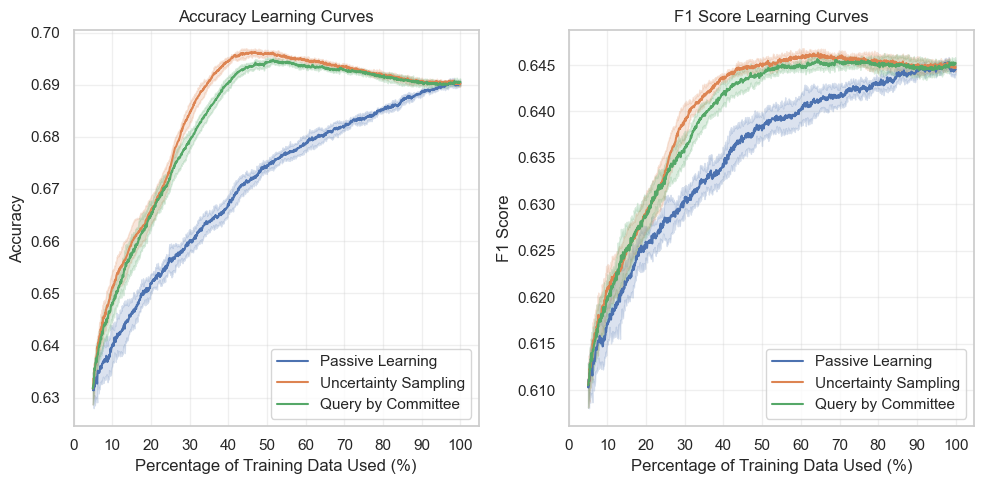

In [30]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

result_dict = {
    "Passive Learning": {
        "accuracy": accuracy_passive,
        "f1": f1_passive
    },
    "Uncertainty Sampling": {
        "accuracy": accuracy_uncertainty,
        "f1": f1_uncertainty
    },
    "Query by Committee": {
        "accuracy": accuracy_QBC,
        "f1": f1_QBC
    },
    # Add more groups as needed
}

plot_learning_curves(result_dict, save_path="classification.png")

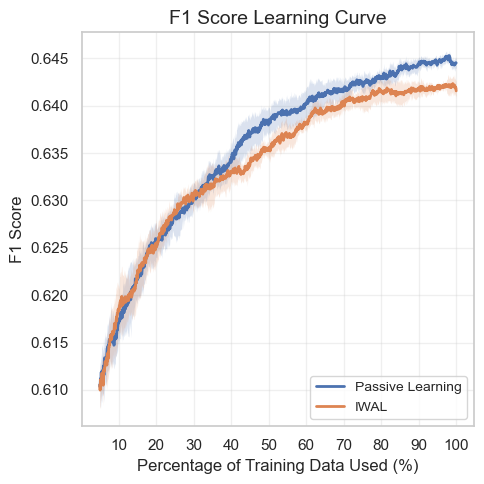

In [23]:
def plot_f1_learning_curve(result_dict, save_path=None, dpi=300, title="F1 Score Learning Curve"):
    """
    Plot F1 score learning curves across multiple experiments with std deviation bands.
    X-axis shows percentage of training data (10%, 20%, ..., 100%) with ticks every 10%.

    Args:
        result_dict: Dictionary containing experimental results in format:
            {
                "experiment1": {
                    "f1": [n_runs arrays of length n_samples],  # e.g., 1267 points (5% to 100%)
                },
                ...
            }
        save_path: Path to save the figure (if None, figure won't be saved)
        dpi: Resolution of the output figure
        title: Title of the plot
    """
    plt.figure(figsize=(5, 5))
    
    # Generate percentage labels (assuming data ranges from 5% to 100%)
    n_points = len(next(iter(result_dict.values()))["f1"][0])
    percentages = np.linspace(5, 100, n_points)  # 5%, 6%, ..., 100%
    
    # Set x-ticks every 10%
    xticks = np.arange(10, 101, 10)  # [10, 20, ..., 100]
    
    for exp_name, results in result_dict.items():
        f1_data = np.array(results["f1"])
        mean_f1 = np.mean(f1_data, axis=0)
        std_f1 = np.std(f1_data, axis=0)
        
        # Plot mean F1 curve
        line = plt.plot(percentages, mean_f1, label=exp_name, linewidth=2)[0]
        
        # Add std deviation band
        plt.fill_between(
            percentages,
            mean_f1 - std_f1,
            mean_f1 + std_f1,
            color=line.get_color(),
            alpha=0.2,
            linewidth=0  # Remove edge lines for smoother fill
        )
    
    plt.xlabel('Percentage of Training Data Used (%)', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(xticks)  # Force ticks every 10%
    plt.legend(fontsize=10, loc='lower right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    plt.show()

import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")
with open('./results/classification_IWAL3.pkl', 'rb') as f:
    results_IWAL = pickle.load(f)
    accuracy_IWAL = [run[:1267] for run in results_IWAL['accuracy']]
    f1_IWAL = [run[:1267] for run in results_IWAL['f1']]
    queried_IWAL = results_IWAL['queried']
    seen_IWAL = results_IWAL['seen']

result_dict = {
    "Passive Learning": {
        "accuracy": accuracy_passive,
        "f1": f1_passive
    },
    "IWAL": {
        "accuracy": accuracy_IWAL,
        "f1": f1_IWAL
    },
    # Add more groups as needed
}

plot_f1_learning_curve(result_dict, save_path="classification_f1_IWAL.png", title="F1 Score Learning Curve")

Final Query Ratio: 76.53%


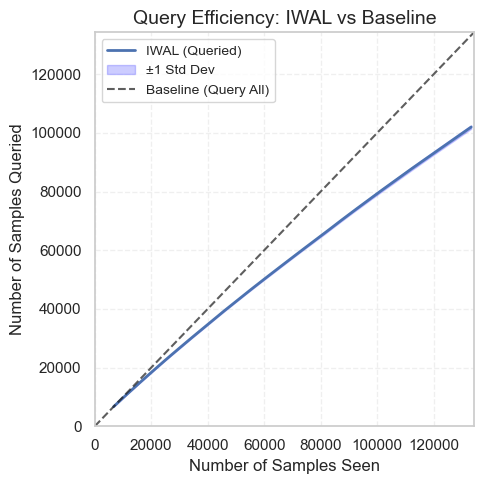

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

with open('./results/classification_IWAL3.pkl', 'rb') as f:
    results_IWAL = pickle.load(f)
    accuracy_IWAL = results_IWAL['accuracy']
    f1_IWAL = results_IWAL['f1']
    queried_IWAL = results_IWAL['queried']
    seen_IWAL = results_IWAL['seen']

# Align the lengths of queried_IWAL and seen_IWAL
max_len = max(len(seen) for seen in seen_IWAL)
seen_array = np.zeros((len(seen_IWAL), max_len))
queried_array = np.zeros((len(queried_IWAL), max_len))

for i in range(len(seen_IWAL)):
    current_seen = seen_IWAL[i]
    current_queried = queried_IWAL[i]
    seen_array[i, :len(current_seen)] = current_seen
    queried_array[i, :len(current_queried)] = current_queried

# Calculate mean and std
mean_seen = np.mean(seen_array, axis=0) + 6665
mean_queried = np.mean(queried_array, axis=0)
std_queried = np.std(queried_array, axis=0)

# Plotting
plt.figure(figsize=(5, 5))
plt.plot(mean_seen, mean_queried, 'b-', label='IWAL (Queried)', linewidth=2)
plt.fill_between(
    mean_seen,
    mean_queried - std_queried,
    mean_queried + std_queried,
    color='blue',
    alpha=0.2,
    label='±1 Std Dev'
)

# Add baseline line
max_val = max(np.max(mean_seen), np.max(mean_queried)) + 1000
plt.plot([0, max_val], [0, max_val], 'k--', label='Baseline (Query All)', linewidth=1.5, alpha=0.7)
plt.xlabel('Number of Samples Seen', fontsize=12)
plt.ylabel('Number of Samples Queried', fontsize=12)
plt.title('Query Efficiency: IWAL vs Baseline', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.tight_layout()

# Print final query ratio
query_ratio = mean_queried[-1] / mean_seen[-1]
print(f"Final Query Ratio: {query_ratio:.2%}")

plt.savefig("IWAL_query_efficiency.png", dpi=300, bbox_inches='tight')
plt.show()